## Homework 7 
### Harsha Raidurgam Venkat

In [83]:
import pandas as pd
import altair as alt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn import metrics
from prettytable import PrettyTable
import seaborn as sns
import warnings
from math import log
from scipy.stats import norm
from itertools import cycle
from numpy import interp
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import label_binarize, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix 

In [84]:
# *** Install the below libraries to execute the code ***

# pip install PrettyTable
# pip install imblearn
# pip install altair

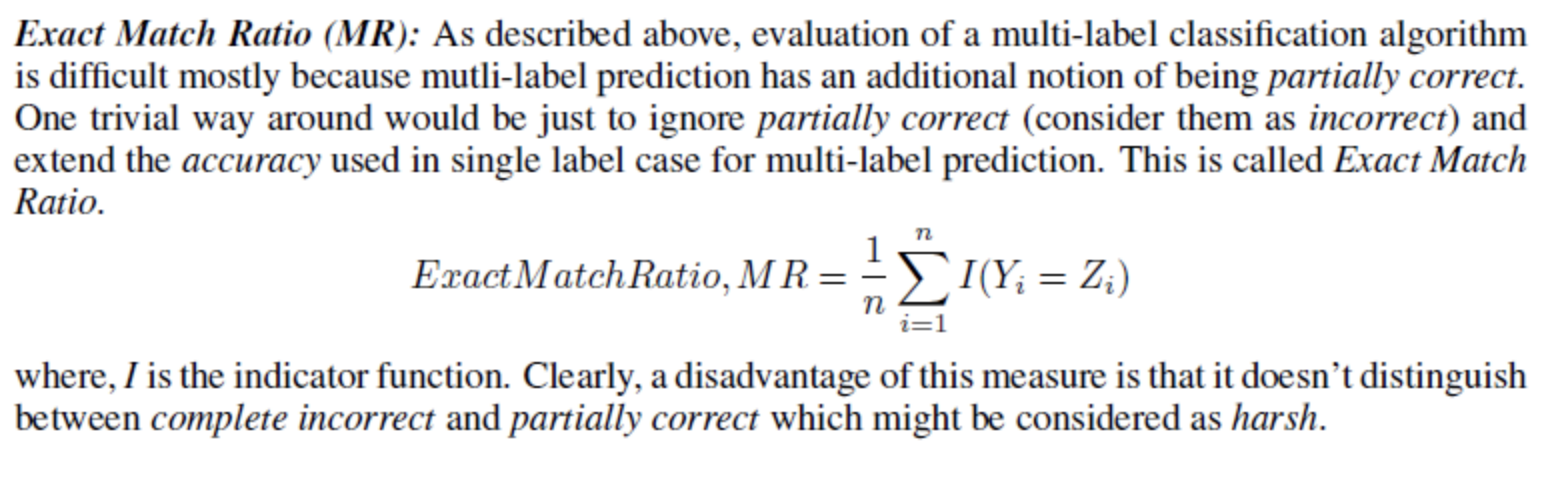
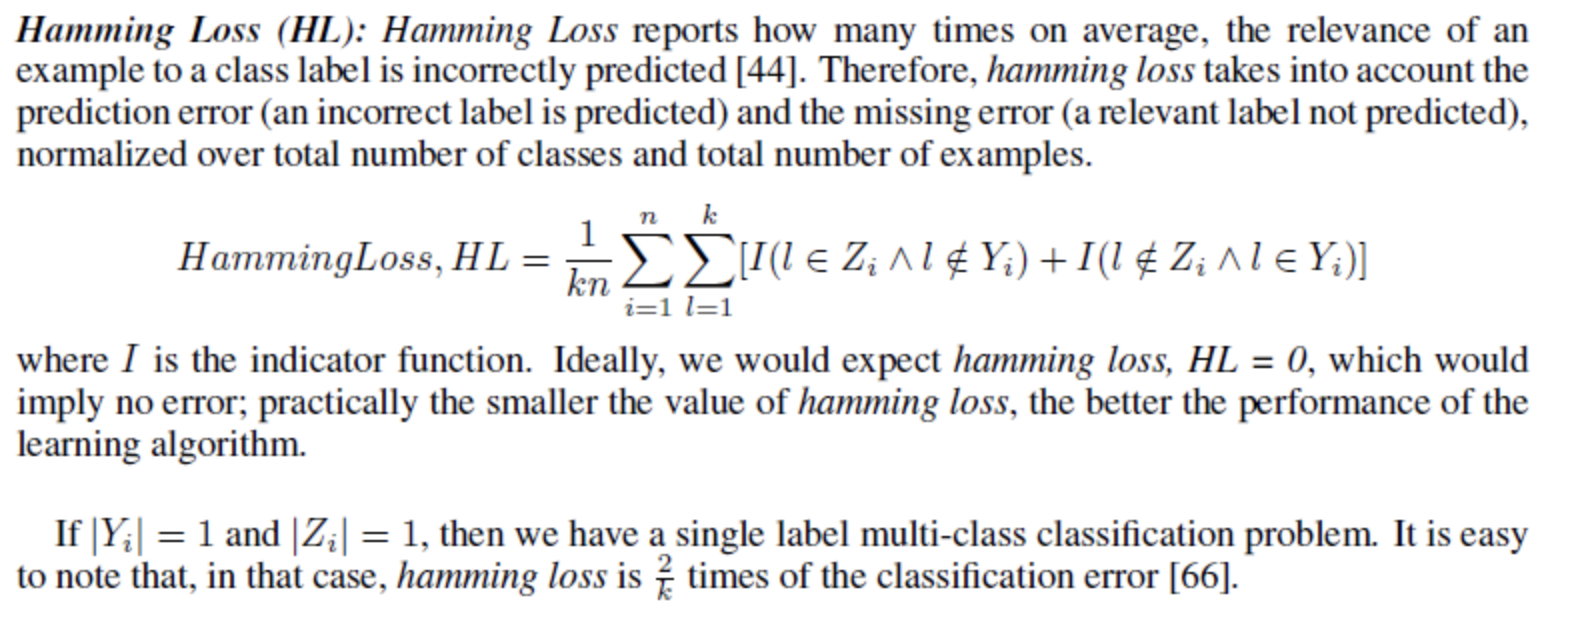

In [94]:
def binarize_labels(dataset):
    for label in (["Family","Genus","Species"]):
        col = dataset[label]
        category = []
        print('\nClass assignment for :',label)
        for i in col.unique():
            category.append(i)
        for indx,i in enumerate(category):
            print("Class",indx,"is",i)
            col.replace(i,indx, inplace=True)
    return dataset

def format_table(dic):
    
    table = PrettyTable()
    
    # remove_set = ["Pruned Features","Report"]
    for key,val in dic.items():
        # if key not in remove_set:
        table.add_column(key,val)
            
    return table

def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    https://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true))
        #print('set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        #print('tmp_a: {0}'.format(tmp_a))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def scalar_standardization(x_):
    
    sc = StandardScaler()
    X_std_df = pd.DataFrame(sc.fit_transform(x_), columns = x_.columns)
    
    return X_std_df

def compute_metrics(y_pred_,y_test_):
    
    y_pred = np.stack((y_pred_[0], y_pred_[1],y_pred_[2]), axis=1)
    y_test = np.stack((y_test_[0], y_test_[1],y_test_[2]), axis=1)
    
    emscore = 0
    ham_loss_count = 0
    
    for i in range(0,y_test.shape[0]):
        count_EM = 0
        for j in range(0,y_test.shape[1]):
            if y_test[i][j]==y_pred[i][j]:
                count_EM += 1
            else:
                ham_loss_count += 1
        if count_EM==3:
            emscore += 1
    em_score = emscore / y_test.shape[0]
    hamming_Loss = ham_loss_count / (y_test.shape[0] * y_test.shape[1])
    
    return em_score, hamming_Loss

def plt_confusion_matrix(clf, X_test, y_test,class_names):
    
    np.set_printoptions(precision=2)
    titles_options = [("Confusion matrix", None)]
    
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(clf, X_test, y_test, 
                                    display_labels=class_names,
                                    cmap=plt.cm.Blues, 
                                    normalize=normalize)
        disp.ax_.set_title(title)
        #print(title)
        #print(disp.confusion_matrix)
    plt.show()

def plot_multiclass_roc(y_test, y_score, n_classes):
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    lw=2
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])
        
    # Finally average it and compute AUC
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    # Plot all ROC curves
    plt.figure(num=None, figsize=(10, 6), dpi=75, edgecolor='k')
    sns.set(style="darkgrid")
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','green',
                    'darkblue','brown','white','lightblue','pink','red'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (AUC = {1:0.3f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05,1.05])
    plt.ylim([-0.05,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for multi-class classification')
    plt.legend(loc="lower right")
    plt.show()

def one_hot_encoder(y_test):
      
    le = LabelEncoder()
    le.fit(y_test)
    y_transform = le.transform(y_test)
    
    n_classes=len(np.unique(y_test))
    y_test_one_hot = np.zeros((y_transform.shape[0],n_classes))
    
    for i in range(y_transform.shape[0]):
        for j in range(0,n_classes):
            if y_transform[i]==j:
                y_test_one_hot[i][j]=1
                
    return y_test_one_hot

In [86]:
dataset_ = pd.read_csv('Frogs_MFCCs.csv', sep = ",", header = 'infer')
dataset = binarize_labels(dataset_)
train_set, test_set = train_test_split(dataset, test_size=0.3)


Class assignment for : Family
Class 0 is Leptodactylidae
Class 1 is Dendrobatidae
Class 2 is Hylidae
Class 3 is Bufonidae

Class assignment for : Genus
Class 0 is Adenomera
Class 1 is Ameerega
Class 2 is Dendropsophus
Class 3 is Hypsiboas
Class 4 is Leptodactylus
Class 5 is Osteocephalus
Class 6 is Rhinella
Class 7 is Scinax

Class assignment for : Species
Class 0 is AdenomeraAndre
Class 1 is Ameeregatrivittata
Class 2 is AdenomeraHylaedactylus
Class 3 is HylaMinuta
Class 4 is HypsiboasCinerascens
Class 5 is HypsiboasCordobae
Class 6 is LeptodactylusFuscus
Class 7 is OsteocephalusOophagus
Class 8 is Rhinellagranulosa
Class 9 is ScinaxRuber



 ------------------ SVM with Gaussian kernel (Binary Relevance method) ------------------ 


 ------- Cross Validating for Family label ------- 

Fitting 10 folds for each of 375 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 12.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 15.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed: 21.4min finished


Precision Score for label - Family : [0.99 0.99 0.98 1.  ]
Recall Score for label - Family : [0.99 1.   0.99 0.73]


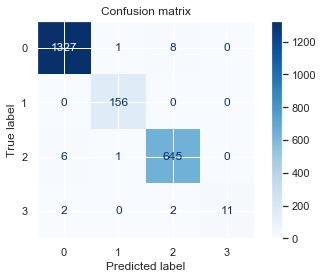

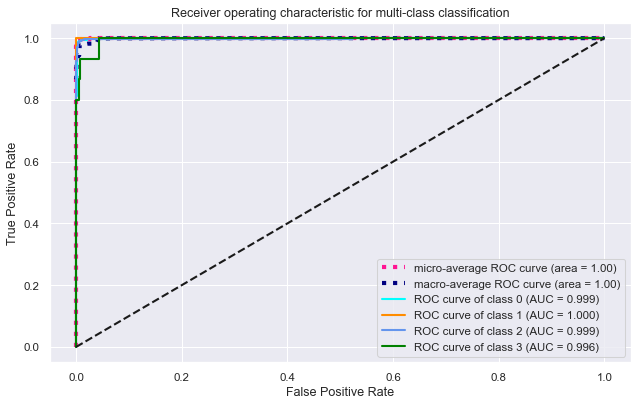


 ------- Cross Validating for Genus label ------- 

Fitting 10 folds for each of 375 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 22.5min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed: 32.0min finished


Precision Score for label - Genus : [0.99 0.99 0.98 0.98 0.96 1.   1.   0.98]
Recall Score for label - Genus : [0.99 1.   0.91 1.   0.97 0.91 0.73 0.98]


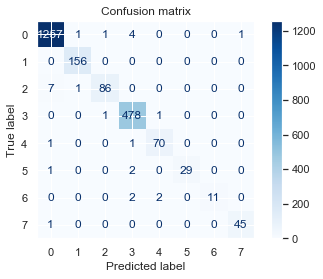

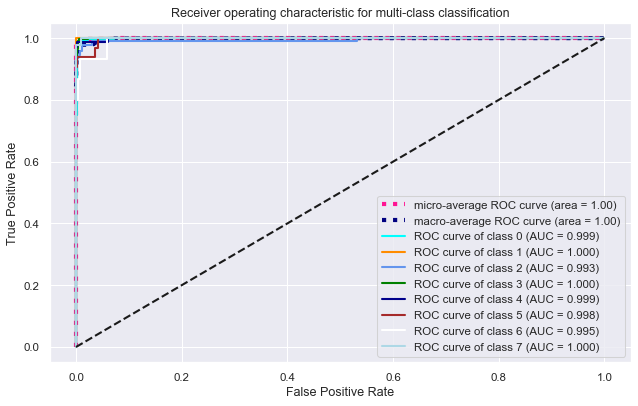


 ------- Cross Validating for Species label ------- 

Fitting 10 folds for each of 375 candidates, totalling 3750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 32.1min
[Parallel(n_jobs=-1)]: Done 3750 out of 3750 | elapsed: 36.9min finished


Precision Score for label - Species : [0.98 0.99 1.   0.98 0.97 0.99 0.96 0.97 1.   0.98]
Recall Score for label - Species : [0.98 1.   1.   0.93 0.99 0.99 0.99 0.91 0.73 0.98]


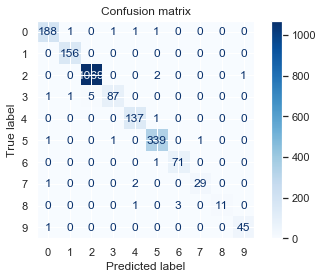

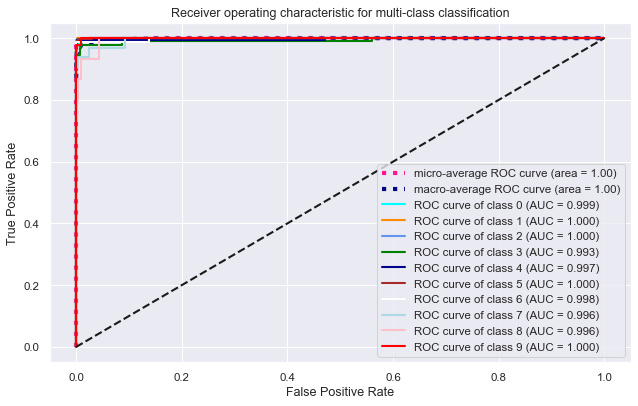

+----------------+----------------------+----------------------+----------------------+
|   Parameters   |        Family        |        Genus         |       Species        |
+----------------+----------------------+----------------------+----------------------+
|     Kernel     |         rbf          |         rbf          |         rbf          |
|     Gamma      |         3.2          |         2.6          |         2.1          |
|       C        |  2.371373705661655   |  2.371373705661655   |  4.216965034285822   |
| Best CV Score  |  0.9946377291804727  |  0.9936452712297644  |  0.9932488402915839  |
|  Hamming Loss  | 0.009263547938860583 | 0.012505789717461788 | 0.012505789717461788 |
| Training Score |  0.9990071485305798  |  0.9990071485305798  |  0.9994042891183479  |
| Testing Score  |  0.9907364520611394  |  0.9874942102825383  |  0.9874942102825383  |
+----------------+----------------------+----------------------+----------------------+

Exact Match score is: 0.9856415

In [88]:
def gaussian_svc():
    
    print("\n ------------------ SVM with Gaussian kernel (Binary Relevance method) ------------------ \n")
    
    C_range = np.logspace(-1, 2, num=25)
    gamma_range = np.linspace(2.1, 3.5, 15)

    labels = ["Family","Genus","Species"]
    report = {"Parameters" : ["Kernel","Gamma","C","Best CV Score",
                              "Hamming Loss","Training Score",
                              "Testing Score"],
              "Family":[],
              "Genus":[],
              "Species":[]}
    y_pred_all = []
    y_test_all = []
    
    for label in labels:
        
        print('\n ------- Cross Validating for',label,'label ------- \n')
        cv_method = StratifiedKFold(n_splits=10)
        para_grid = { 'estimator__C': C_range, 
                      'estimator__kernel': ['rbf'],
                      'estimator__gamma': gamma_range
                      }
        classifier = OneVsRestClassifier(SVC(probability=True),n_jobs=-1)
        grid_search = GridSearchCV(estimator=classifier, 
                            param_grid=para_grid, 
                            cv=cv_method,
                            verbose=1, 
                            scoring='accuracy',
                            n_jobs=-1)

        X_train = train_set.iloc[:,0:22]
        y_train = np.array(train_set[label])
        X_test = test_set.iloc[:,0:22]
        y_test = np.array(test_set[label])
        y_test_all.append(y_test)
        
        class_names = np.unique(y_train)
        n_classes=len(class_names)

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_pred_all.append(y_pred)
        
        report[label].append(grid_search.best_params_['estimator__kernel'])
        report[label].append(grid_search.best_params_['estimator__gamma'])
        report[label].append(grid_search.best_params_['estimator__C'])
        report[label].append(grid_search.best_score_)
        report[label].append(format(metrics.hamming_loss(y_test,
                                                         y_pred)))
        report[label].append(grid_search.score(X_train,y_train))
        report[label].append(grid_search.score(X_test,y_test))
        
        print("Precision Score for label -",label,":",metrics.
              precision_score(y_test, y_pred, average=None, sample_weight=None))
        print("Recall Score for label -",label,":",metrics.
              recall_score(y_test, y_pred, average=None, sample_weight=None))
        
        plt_confusion_matrix(grid_search, X_test, y_test, class_names)
        plot_multiclass_roc(one_hot_encoder(y_test), 
                            grid_search.predict_proba(X_test), 
                            n_classes)
        
    print(format_table(report))
    print("")
    em_score, h_loss = compute_metrics(y_pred_all,y_test_all)
    print("Exact Match score is:", em_score)
    print("Hamming Loss is:", h_loss)

gaussian_svc()


 ------------------ SVM with L1 Regularization (Binary Relevance method) ------------------ 


 ------- Cross Validating for Family label ------- 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished


Precision Score for label - Family : [0.95 0.9  0.93 0.  ]
Recall Score for label - Family : [0.97 0.94 0.89 0.  ]


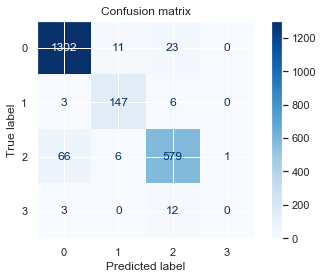

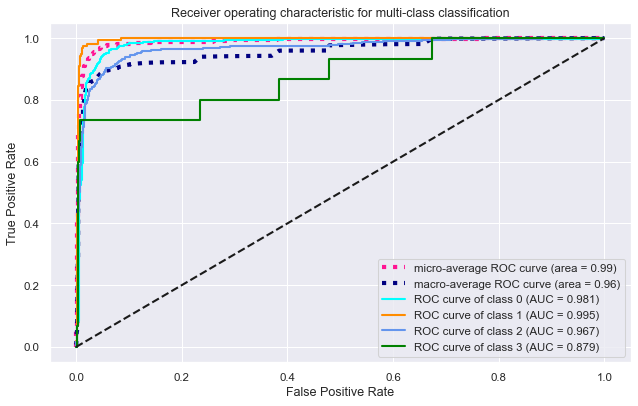


 ------- Cross Validating for Genus label ------- 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.6min finished


Precision Score for label - Genus : [0.97 0.92 0.91 0.93 0.96 1.   0.92 0.95]
Recall Score for label - Genus : [0.99 0.97 0.68 0.96 0.92 0.44 0.73 0.89]


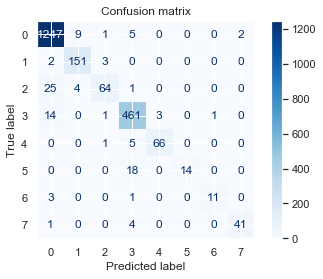

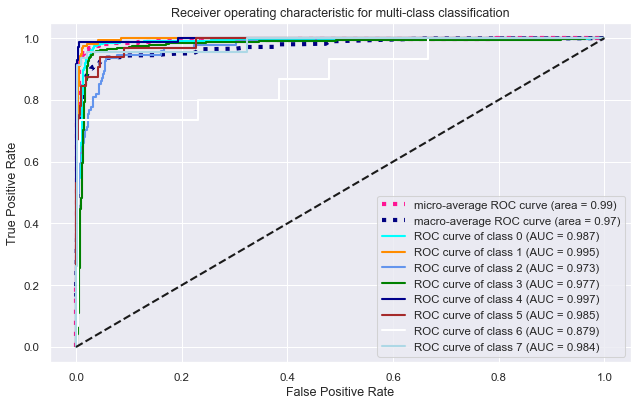


 ------- Cross Validating for Species label ------- 

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   31.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  5.7min finished


Precision Score for label - Species : [0.92 0.93 0.99 0.94 0.91 0.92 0.92 1.   0.85 0.98]
Recall Score for label - Species : [0.94 0.97 1.   0.77 0.93 0.96 0.93 0.59 0.73 0.91]


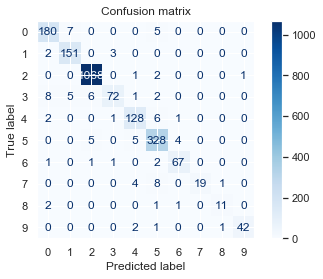

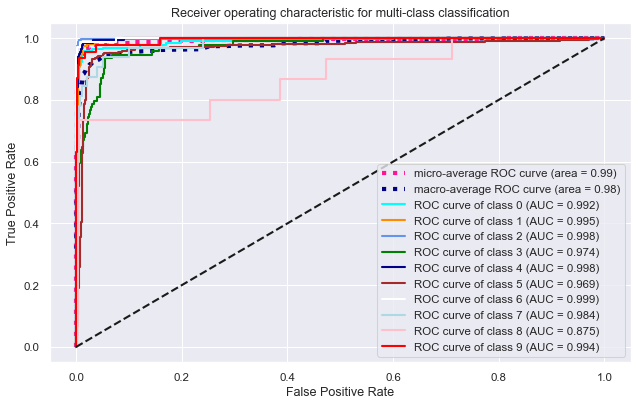

+----------------+---------------------+----------------------+---------------------+
|   Parameters   |        Family       |        Genus         |       Species       |
+----------------+---------------------+----------------------+---------------------+
|    Penalty     |          l1         |          l1          |          l1         |
|       C        |  21.54434690031882  |  31.622776601683793  |  6.812920690579611  |
| Best CV Score  |  0.9338741361355675 |  0.9531339739341729  |  0.9575029978857017 |
|  Hamming Loss  | 0.06067623899953682 | 0.048170449282075034 | 0.04307549791570171 |
| Training Score |  0.9348689436060366 |  0.9563145353455124  |  0.9626687847498014 |
| Testing Score  |  0.9393237610004632 |  0.951829550717925   |  0.9569245020842982 |
+----------------+---------------------+----------------------+---------------------+

Exact Match score is: 0.9180176007410839
Hamming Loss is: 0.050640728732437856


In [89]:
def l1_penalized():
    
    print("\n ------------------ SVM with L1 Regularization (Binary Relevance method) ------------------ \n")
    
    C_range = np.logspace(-1, 3, num=25) 
    labels = ["Family","Genus","Species"]
    report = {"Parameters" : ["Penalty","C","Best CV Score",
                              "Hamming Loss","Training Score",
                              "Testing Score"],
              "Family":[],
              "Genus":[],
              "Species":[]}
    y_pred_all = []
    y_test_all = []

    for label in labels:

        print('\n ------- Cross Validating for',label,'label ------- \n')
        
        cv_method = StratifiedKFold(n_splits=10)
        para_grid = [{'estimator__C': C_range, 
                    'estimator__penalty': ['l1'],
                    'estimator__max_iter': [2000]
                    }]
        classifier = OneVsRestClassifier(LinearSVC(dual=False),n_jobs=-1)
        grid_search = GridSearchCV(estimator=classifier, 
                            param_grid=para_grid, 
                            cv=cv_method,
                            verbose=1, 
                            scoring='accuracy',
                            n_jobs=-1)
        
        X_train = train_set.iloc[:,0:22]
        y_train = np.array(train_set[label])
        X_test = test_set.iloc[:,0:22]
        y_test = np.array(test_set[label])
        y_test_all.append(y_test)
        
        class_names = np.unique(y_train)
        n_classes=len(class_names)
        
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_pred_all.append(y_pred)

        report[label].append(grid_search.best_params_['estimator__penalty'])
        report[label].append(grid_search.best_params_['estimator__C'])
        report[label].append(grid_search.best_score_)
        report[label].append(format(metrics.hamming_loss(y_test,
                                                         y_pred)))
        report[label].append(grid_search.score(X_train,y_train))
        report[label].append(grid_search.score(X_test,y_test))
        
        print("Precision Score for label -",label,":",metrics.
              precision_score(y_test, y_pred, average=None, sample_weight=None))
        print("Recall Score for label -",label,":",metrics.
              recall_score(y_test, y_pred, average=None, sample_weight=None))
        
        plt_confusion_matrix(grid_search, X_test, y_test, class_names)
        plot_multiclass_roc(one_hot_encoder(y_test), 
                            grid_search.decision_function(X_test), 
                            n_classes)
        
    print(format_table(report))
    print("")
    em_score, h_loss = compute_metrics(y_pred_all,y_test_all)
    print("Exact Match score is:", em_score)
    print("Hamming Loss is:", h_loss)

l1_penalized()


 ------------------ SVM with L1 regularization and SMOTE (Binary Relevance method) ------------------ 


 ------- Cross Validating for Family label ------- 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.6min finished


Precision Score for label - Family : [0.97 0.73 0.94 0.24]
Recall Score for label - Family : [0.95 0.99 0.85 0.73]


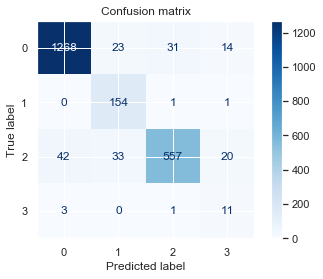

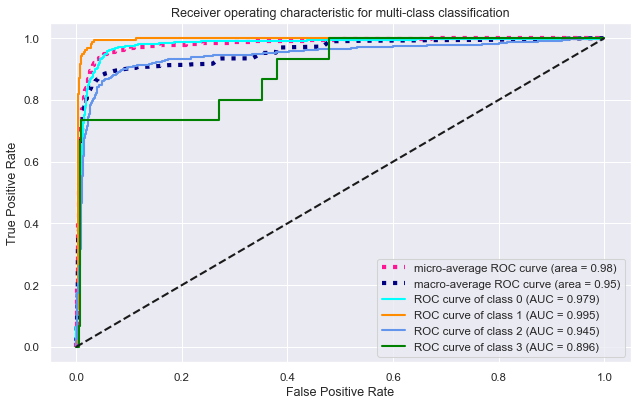


 ------- Cross Validating for Genus label ------- 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 15.2min finished


Precision Score for label - Genus : [0.98 0.81 0.66 0.97 0.87 0.53 0.32 0.92]
Recall Score for label - Genus : [0.92 0.96 0.83 0.91 0.94 0.81 0.73 0.96]


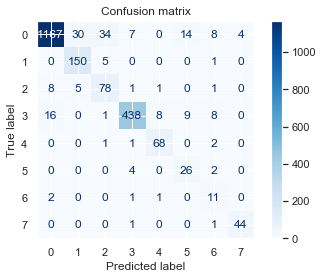

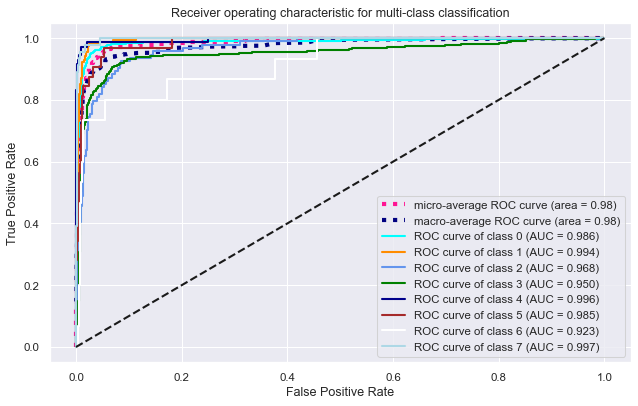


 ------- Cross Validating for Species label ------- 

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 18.1min finished


Precision Score for label - Species : [0.96 0.92 0.99 0.87 0.88 0.95 0.89 0.93 0.48 0.91]
Recall Score for label - Species : [0.93 0.93 0.99 0.88 0.92 0.94 0.93 0.78 0.73 0.91]


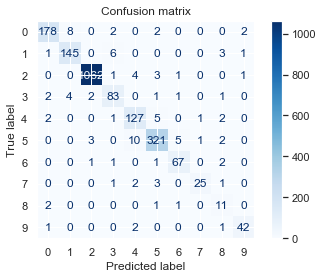

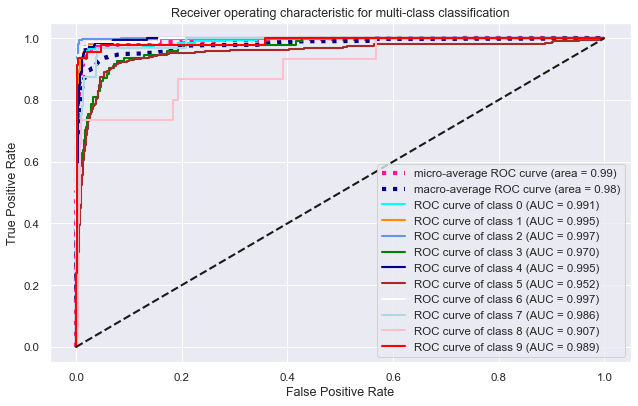

+----------------+---------------------+---------------------+---------------------+
|   Parameters   |        Family       |        Genus        |       Species       |
+----------------+---------------------+---------------------+---------------------+
|    Penalty     |          l1         |          l1         |          l1         |
|       C        |  88.58667904100822  |  143.8449888287663  |  379.2690190732246  |
| Best CV Score  |  0.9520931015128273 |  0.9572075737093867 |  0.9599334995843722 |
|  Hamming Loss  | 0.07827698008337193 | 0.08198239925891616 | 0.04539138490041686 |
| Training Score |  0.9527399481193255 |  0.9581600831600832 |  0.9607647547797173 |
| Testing Score  |  0.9217230199166281 |  0.9180176007410839 |  0.9546086150995832 |
+----------------+---------------------+---------------------+---------------------+

Exact Match score is: 0.8675312644742936
Hamming Loss is: 0.06855025474756832


In [90]:
def smote():
    
    print("\n ------------------ SVM with L1 regularization and SMOTE (Binary Relevance method) ------------------ \n")
    
    C_range = np.logspace(-1, 3, num=20) 
    y_pred_all, y_test_all = [] , []
    labels = ["Family","Genus","Species"]
    report = {"Parameters" : ["Penalty","C","Best CV Score",
                              "Hamming Loss","Training Score",
                              "Testing Score"],
              "Family":[],
              "Genus":[],
              "Species":[]}
    
    for label in labels:
        
        print('\n ------- Cross Validating for',label,'label ------- \n')
        
        cv_method = StratifiedKFold(n_splits=10)
        para_grid = [{'estimator__C': C_range, 
                      'estimator__penalty': ['l1']
                      }]
        classifier = OneVsRestClassifier(LinearSVC(dual=False),n_jobs=-1)
        grid_search = GridSearchCV(estimator=classifier, 
                            param_grid=para_grid, 
                            cv=cv_method,
                            verbose=1, 
                            scoring='accuracy',
                            n_jobs=-1)
        
        X_train_ = train_set.iloc[:,0:22]
        y_train_ = np.array(train_set[label])
        X_test = test_set.iloc[:,0:22]
        y_test = np.array(test_set[label])
        y_test_all.append(y_test)
        
        sm = SMOTE(random_state=12)
        X_train, y_train = sm.fit_sample(X_train_, y_train_)
     
        class_names = np.unique(y_train)
        n_classes=len(class_names)
        
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_pred_all.append(y_pred)

        report[label].append(grid_search.best_params_['estimator__penalty'])
        report[label].append(grid_search.best_params_['estimator__C'])
        report[label].append(grid_search.best_score_)
        report[label].append(format(metrics.hamming_loss(y_test,
                                                         y_pred)))
        report[label].append(grid_search.score(X_train,y_train))
        report[label].append(grid_search.score(X_test,y_test))

        print("Precision Score for label -",label,":",metrics.
              precision_score(y_test, y_pred, average=None, sample_weight=None))
        print("Recall Score for label -",label,":",metrics.
              recall_score(y_test, y_pred, average=None, sample_weight=None))
        
        plt_confusion_matrix(grid_search, X_test, y_test, class_names)
        plot_multiclass_roc(one_hot_encoder(y_test), 
                            grid_search.decision_function(X_test), 
                            n_classes)
           
    print(format_table(report))
    print("")
    em_score, h_loss = compute_metrics(y_pred_all,y_test_all)
    print("Exact Match score is:", em_score)
    print("Hamming Loss is:", h_loss)

smote()

| **Classification Methods**  | **Exact Match score**  | **Hamming Loss**  |
|---|---|---|
| SVM with Gaussian kernel  | 0.986  | 0.0011  |
| SVM with L1 regularization  | 0.918  | 0.051  |
| SVM with L1 regularization and SMOTE  | 0.868  | 0.069  |

The SVM with Gaussian kernel algorithm achieves the highest Exact Match score and the lowest Hamming Loss compared to the other two algorithms. Here the algorithm creates nonlinear decision boundaries among the classes and the data are not completely linearly separable.

However, it should be noted that the other two algorithms achieved good scores too even though the SMOTE approach required a lot of computational power in order to apply the 10-fold CV approach for 20 values of the regularization parameter C. SMOTE did improve the training accuracy for each of the three labels however, the test accuracy reduced for Family and Genus label as compared to L1 regularization without SMOTE.  

## Classifier Chain method

In [91]:
def classifier_chain():
    
    C_range = np.logspace(-1, 3, num=25)
    gamma_range = np.linspace(0.1, 3.5, 35)
    labels = ["Family","Genus","Species"]
    report = {"Parameters" : ["Kernel","Gamma","C","Best CV Score",
                              "Hamming Loss","Training Score",
                              "Testing Score"],
              "Family":[],
              "Genus":[],
              "Species":[]}
    y_pred_all = []
    y_test_all = []
    i=0
    for label in labels:
    
        cv_method = StratifiedKFold(n_splits=10)
        para_grid = { 'estimator__C': C_range, 
                      'estimator__kernel': ['rbf'],
                      'estimator__gamma': gamma_range
                      }
        classifier = OneVsRestClassifier(SVC(),n_jobs=-1)
        grid_search = GridSearchCV(estimator=classifier, 
                            param_grid=para_grid, 
                            cv=cv_method,
                            verbose=1, 
                            scoring='accuracy',
                            n_jobs=-1)
        
        # Consider ith feature also for next augmented classifier
        X_train = train_set.iloc[:,0:22+i]
        X_test = test_set.iloc[:,0:22]
        
        if i == 1:
            X_test_ndarr = np.concatenate((X_test, 
                                           np.expand_dims(y_pred_all[0], axis=1)), axis=1)
            X_test = pd.DataFrame(data=X_test_ndarr)
            
        elif i == 2:
            X_test_ndarr = np.concatenate((X_test, 
                                           np.expand_dims(y_pred_all[0], axis=1),
                                          np.expand_dims(y_pred_all[1], axis=1)), axis=1)
            X_test = pd.DataFrame(data=X_test_ndarr)
        
        y_train = np.array(train_set[label])
        y_test = np.array(test_set[label])
        y_test_all.append(y_test)

        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        y_pred_all.append(y_pred)
        
        report[label].append(grid_search.best_params_['estimator__kernel'])
        report[label].append(grid_search.best_params_['estimator__gamma'])
        report[label].append(grid_search.best_params_['estimator__C'])
        report[label].append(grid_search.best_score_)
        report[label].append(format(metrics.hamming_loss(y_test,
                                                         y_pred)))
        report[label].append(grid_search.score(X_train,y_train))
        report[label].append(grid_search.score(X_test,y_test))
        i+=1
        
    table = PrettyTable()
    for key,val in report.items():
        table.add_column(key,val)
        
    table.field_names = ["Parameters", "Base Classifier with 0 labels", 
                         "Classifier with 1 label", "Classifier with 2 labels"]
    print(table)
    print("")
    em_score, h_loss = compute_metrics(y_pred_all,y_test_all)
    print("Exact Match score is:", em_score)
    print("Hamming Loss is:", h_loss)

classifier_chain()

Fitting 10 folds for each of 875 candidates, totalling 8750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 8750 out of 8750 | elapsed:  9.6min finished


Fitting 10 folds for each of 875 candidates, totalling 8750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 8750 out of 8750 | elapsed: 12.8min finished


Fitting 10 folds for each of 875 candidates, totalling 8750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  6.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 14.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 16.5min
[Parallel(n_jobs=-1)]: Done 8750 out of 8750 | elapsed: 17.1min finished


+----------------+-------------------------------+-------------------------+--------------------------+
|   Parameters   | Base Classifier with 0 labels | Classifier with 1 label | Classifier with 2 labels |
+----------------+-------------------------------+-------------------------+--------------------------+
|     Kernel     |              rbf              |           rbf           |           rbf            |
|     Gamma      |       3.0999999999999996      |           1.3           |           0.5            |
|       C        |       2.1544346900318834      |           10.0          |    4.6415888336127775    |
| Best CV Score  |       0.9946377291804727      |    0.9978154880242356   |    0.9996031746031747    |
|  Hamming Loss  |      0.009263547938860583     |   0.01157943492357573   |   0.012505789717461788   |
| Training Score |       0.9990071485305798      |    0.999801429706116    |    0.999801429706116     |
| Testing Score  |       0.9907364520611394      |    0.98842056

#### The Classifier Chain method produced a higher Exact Match score than the Binary Relevance method. This behavior was expected since the Classifier Chain method takes into account the correlation between the labels while the Binary Relevance does not.